<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Formulating-the-payoffs" data-toc-modified-id="Formulating-the-payoffs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Formulating the payoffs</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Analyzing-the-dynamics" data-toc-modified-id="Analyzing-the-dynamics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyzing the dynamics</a></span><ul class="toc-item"><li><span><a href="#Case-1:-V->-C" data-toc-modified-id="Case-1:-V->-C-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Case 1: V &gt; C</a></span></li><li><span><a href="#Case-2:-V-=-C" data-toc-modified-id="Case-2:-V-=-C-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Case 2: V = C</a></span></li><li><span><a href="#Case-3:-V-<-C" data-toc-modified-id="Case-3:-V-<-C-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Case 3: V &lt; C</a></span></li></ul></li></ul></div>

In [4]:
import ternary
import numpy as np
import matplotlib.patches as mpatches
from ternary.helpers import project_point
from matplotlib.legend_handler import HandlerPatch
from sympy import *

init_printing()

# Formulating the payoffs

We can analyze a generalized rock paper scissors game by formulating a general payoff matrix.

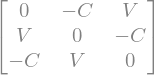

In [5]:
V,C = symbols('V C') #Value and Cost

Payoff_matrix = Matrix([[0, -C, V],[V,0,-C],[-C,V,0]])

Payoff_matrix

In [6]:
#Variables for fitness
wr,wp,ws = symbols('omega_R omega_P omega_S')

#Parameters affecting fitness
w0,s,pr,pp = symbols('omega_0 s p_R p_P')

#Variables for fitness differences (for nullclines)
alpha,beta = symbols('alpha beta')


Payoffs for each strategy are obtained from the matrix

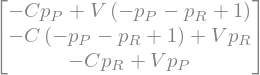

In [7]:
fitness_payoffs = Payoff_matrix*Matrix([pr,pp,(1-pr-pp)])

fitness_payoffs

In [8]:
#Payoff equations for the three strategies
wr = w0 + s*(fitness_payoffs[0])
wp = w0 + s*(fitness_payoffs[1])
ws = w0 + s*(fitness_payoffs[2])

If we wish, we can also plot nullclines (curves for which fitnesses of two strategies are equal). Fixed points are points at which all nullclines intersect

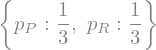

In [9]:
alpha = wr-wp
beta = wp-ws

r_p_nullcline = solve([alpha],pp,pr)
p_s_nullcline = solve([beta],pp,pr)
r_s_nullcline = solve([alpha+beta],pp,pr)


fixed_points = solve([alpha,beta],pr,pp)

fixed_points

Thus, the internal fixed point is always at (1/3,1/3,1/3). 

# Plotting

To implement these nullclines, we need to convert the nullcline equations from symbolic math to Python functions.

In [10]:
def r_p_null_func(PR,v,c):
    
    null_sol = lambdify([V,C,pr],r_p_nullcline[pp],'numpy')
    
    try:
        PP = null_sol(v,c,PR)
    
    except ZeroDivisionError: #Occurs when V=C because of how Sympy implements analytical solutions
        return 
        
    PS = 1-PP-PR
    
    return (PR,PP,PS)

def p_s_null_func(PR,v,c):
    null_sol = lambdify([V,C,pr],p_s_nullcline[pp],'numpy')
    try:
        PP = null_sol(v,c,PR)
    
    except ZeroDivisionError:
        return
        
    PS = 1-PP-PR
    
    return (PR,PP,PS)

def r_s_null_func(PR,v,c):
    null_sol = lambdify([V,C,pr],r_s_nullcline[pp],'numpy')
    try:
        PP = null_sol(v,c,PR)
    
    except ZeroDivisionError:
        return
        
    PS = 1-PP-PR
    
    return (PR,PP,PS)

Since all the frequency values are constrained to lie on a simplex (because sum of all frequencies equals 1), we can plot the system on a _ternary plot_. In a ternary plot, Cartesian distance is converted to distance from the edges of an equilateral triangle. The below functions are to assist with this.<br>
To plot the vector field for trajectories, I have used the replicator equation:

\[
\dot{f_s}(t) = (\omega_{s} - \bar{\omega})f_{s}(t)
\]

where $f_s$ is the frequency of strategy s, $\omega_s$ is the fitness of strategy s, and $\bar{\omega}$ is the mean fitness of the population.

In [11]:
def within_simplex(r): #Find out whether a given point lies within the S_1 simplex
    
    if r is not None:
        if r[0]+r[1]+r[2] <= 1 and r[0] >= 0 and r[1] >= 0 and r[2] >= 0:
            return True
        else:
            return False
    else:
        return False

#Convert the nullclines into Python functions
wr_func = lambdify([pr,pp,V,C,w0,s],wr)
wp_func = lambdify([pr,pp,V,C,w0,s],wp)
ws_func = lambdify([pr,pp,V,C,w0,s],ws)
    
def get_vector(pr,pp,v,c,w0,s):
    
    #get the fitness values
    wr_val = wr_func(pr,pp,v,c,w0,s)
    wp_val = wp_func(pr,pp,v,c,w0,s)
    ws_val = ws_func(pr,pp,v,c,w0,s)
    
    #Get relative fitness
    w_bar = pr*wr_val + pp*wp_val + (1-pr-pp)*ws_val
    wr_val -= w_bar
    wp_val -= w_bar
    ws_val -= w_bar
    
    #Project the 3D Cartesian coordinates onto a 2D simplex
    r_proj = project_point((pr,pp,1-pr-pp))
    dr_proj = project_point((pr*wr_val,pp*wp_val,(1-pr-pp)*ws_val))
    
    return r_proj,dr_proj

def get_color(pr,pp,v,c,w0,s): #To indicate which strategy is best at a given point
    
    wr_val = wr_func(pr,pp,v,c,w0,s)
    wp_val = wp_func(pr,pp,v,c,w0,s)
    ws_val = ws_func(pr,pp,v,c,w0,s)
    
    if wr_val >= wp_val and wr_val >= ws_val:
        return 'red'
    if  wp_val >= wr_val and wp_val >= ws_val:
        return 'green'
    if  ws_val >= wr_val and ws_val >= wp_val:
        return 'blue'
    else:
        return 'black'

#copied below function from stack overflow: https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow
def make_legend_arrow(legend, orig_handle,xdescent, ydescent,width, height, fontsize):
    p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
    return p

In [12]:
def make_ternary_plot(V,C,w0=0,s=1,plot_field=True,plot_nullclines=False,save=False,filename=''):
    
    figure, tax = ternary.figure(scale=1)

    fontsize = 16
    offset = 0.11
    
    #set background
    tax.set_background_color(color="#222222", alpha=0.7)
    
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=1, multiple=1)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=0.5, multiple=0.2,alpha=0.5)
    
    #Depict parameter values
    tax.set_title("V = "+ str(V) + "\nC = " + str(C) + '\nV-C = ' + format(V-C,'.2f'),position=(-0.05,1.5,-0.03),fontsize=18)

    #Label the axes and vertices
    tax.top_corner_label("Pure Paper", fontsize=fontsize,position=(-0.1,1.2,-0.03),offset=0)
    tax.left_corner_label("Pure\nScissors", fontsize=fontsize,position=(-0.05,-0.01,1.1),offset=0)
    tax.right_corner_label("Pure\nRock", fontsize=fontsize,position=(1.05,0,-0.02),offset=0)
    tax.left_axis_label("$P_S$", fontsize=18, offset=0.16)
    tax.right_axis_label("$P_P$", fontsize=18, offset=0.16)
    tax.bottom_axis_label("$P_R$", fontsize=18, offset=0.16)
    
    if plot_nullclines:
        
        pr_list = np.arange(0,1.01,0.01)
        r_p_null = []
        p_s_null = []
        r_s_null = []
        for p in pr_list:
        
            #Get the value of the R-P null
            tuple1 = r_p_null_func(p,V,C)
            if within_simplex(tuple1):
                r_p_null.append(tuple1)
        
            #Get the value of the P-S null
            tuple2 = p_s_null_func(p,V,C)
            if within_simplex(tuple2):
                p_s_null.append(tuple2)
        
            #Get the value of the R-S null
            tuple3 = r_s_null_func(p,V,C)
            if within_simplex(tuple3):
                r_s_null.append(tuple3)
    
        #Plot nullclines
        if len(r_p_null) > 0:
            tax.plot(r_p_null,linewidth=2.0,color='#ffff00',label='R-P nullcline')
        if len(p_s_null) > 0:
            tax.plot(p_s_null,linewidth=2.0,color='#00ffff',label='P-S nullcline')
        if len(r_s_null) > 0:
            tax.plot(r_s_null,linewidth=2.0,color='#ff00ff',label='R-S nullcline')
    
    #draw the vector field
    if plot_field:
        length = 0.02
        prop_list = np.arange(0,1.2,0.05) #Make this finer if you want more arrows
        for PR in prop_list:
            for PP in prop_list:
                if within_simplex((PR,PP,1-PR-PP)):
                    r, dr = get_vector(PR,PP,V,C,w0,s)
                    if np.hypot(dr[0],dr[1]) != 0:
                        dx,dy = length*dr/np.hypot(dr[0],dr[1])
                    else:
                        dx,dy = 0,0
                    color = get_color(PR,PP,V,C,w0,s)
                    tax.get_axes().quiver(r[0],r[1],dx,dy,color=color,width=0.005,scale=0.1,scale_units='inches')
    
    tax.ticks(axis='lbr', fontsize=13, multiple=0.2, linewidth=0.5, tick_formats="%.1f",axes_colors={'l':'white','r':'white','b':'white'}, offset=0.02)    
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    if plot_nullclines:
        tax.legend()
    if plot_field:
        red_arrow = mpatches.FancyArrow(10,10,0.01,0.01,color='red',label='Rock dominates')
        blue_arrow = mpatches.FancyArrow(10,10,0.1,0.1,color='blue',label='Paper dominates')
        green_arrow = mpatches.FancyArrow(10,10,0.1,0.1,color='green',label='Scissors dominates')
        tax.legend(handles = [red_arrow,blue_arrow,green_arrow],handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),})
    
    if save:
        tax.savefig(str(filename+".png"))
    tax.show()

# Analyzing the dynamics

## Case 1: V > C

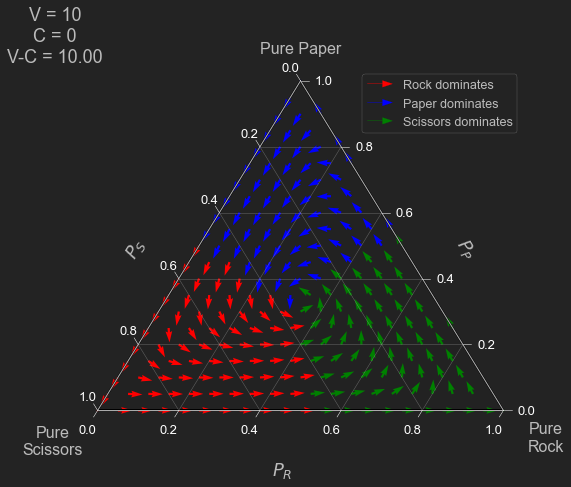

In [13]:
# Note that I'm not plotting nullclines here.

make_ternary_plot(10,0)

When V > C, the interior fixed point is an _attractor_. Trajectories that are not on the edges flow into the fixed point.

## Case 2: V = C

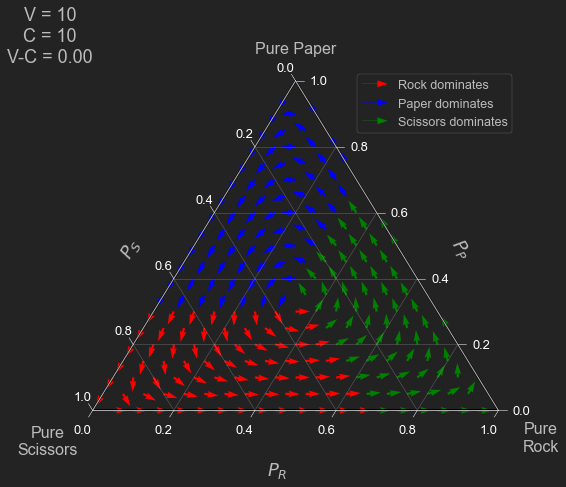

In [19]:
make_ternary_plot(10,10)

When V=C, the game is 'zero-sum'. Here, the internal fixed point is neither an attractor nor a repeller. Trajectories form closed orbits which circle the fixed point.

## Case 3: V < C

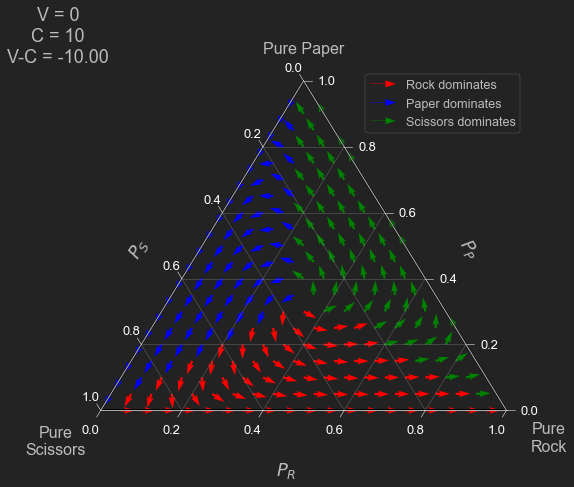

In [18]:
make_ternary_plot(0,10)

When V < C, the internal fixed point is unstable. Trajectories move away from the center and go towards the edges of the simplex. In both computer simulations and real populations, this generally means that one of the strategies will go extinct, even though theoretically, the edges are never reached.